# Testing and Test Driven Development

It may seem as the the point of test driven development is to create software with fewer bugs thanks to testing. This is in part true. Perhaps more importantly TDD encourages you think about the purpose of the code  you are writing upfront. A good analogie TDD is like building a lock and key simaltaneously to ensure they both fit. 



Ensuring your code is well tested helps ensure a novel result is not the outcome of a bug, but at worst an error in the computational method or algorithm you have devised, you have might have the wrong design but it is implemented correctly. TDD will help narrow down the domain where you error lies. 

Scientific software 

Testing can seem like wasted effort, why test when you can forge on and create more features? After all your code is working. For a lot of people new to programming the value of testing is only shown when they get to a stage where their code isn't working and they can't fix it, this likley could have avoided by testing. Creating programms without testing feels fast and moves slowly, whilst using tests is the opposite.


In short, the answer to how often should we be testing is always. 

There are a range of different sorts of tests used by software developers. The tests that you will likley find most useful when creating scientific software are
* Unit tests. These are written to test functions or areas of code. They are written to ensure that functions are working as we expexted. 
* Regression tests. These tests measure whether program output or behaviour are consistent with earlier versions of the program. 
* Integration tests. Integration tests are written  to test that the major parts of of a program work together as expected. 

There are of course other types of tests, but these three are the most likley you will use and encounter if writing scintific software. For this module we are going to focus on unit tests.

Scientific software can be a difficult domain to create tests for. Often you are trying to compute the answer to the question you don't know the answer to a priori. Some possible solutions include comparing your program output to a result that can be calculate analytically, or comparing your output to another piece of softwares output which you have a high degree of trust in its accuracy.





# The TDD cycle

* **_Write a test_** 
    Write a test that doesnt run
* **_Make it run_** 
    Make the test work quickly
*  **_Make it right_** 
    Clean up your code and remove unecessary duplicatioh

When it comes to getting the test to pass quickly, there are techniques frequently used
* **Faking it**: Return constant values and gradually replace them until you have real code
* **Obvious Implementation**. Implement the obvious solution to the problem. Don't fall into the trap of trying to implement the "most" obvious solution, don't overthink it.
* **Triangulation**: Sometimes you want to generalize some code but are not sure how to do it. Triangulation is the process of addingtest cases with different input and expected output to try and force us to genearlize our code to handle all the test cases.



<img src="TDD_cycle.png",width=500,height=500>

## Assertions
The first step toward getting the right answers from our programs is to assume that mistakes will happen and to guard against them. This is called defensive programming, and the most common way to do it is to add assertions to our code so that it checks itself as it runs. An assertion is simply a statement that something must be true at a certain point in a program. When Python sees one, it evaluates the assertion’s condition. If it’s true, Python does nothing, but if it’s false, Python halts the program immediately and prints the error message if one is provided. For example, this piece of code halts as soon as the loop encounters a value that isn’t positive:



In [6]:

numbers = [1.5, 2.3, 0.7, -0.001, 4.4]
total = 0.0
for n in numbers:
    assert n > 0.0, 'Data should only contain positive values'
    total += n
print('total is:', total)


AssertionError: Data should only contain positive values

Programs like the Firefox browser are full of assertions: 10-20% of the code they contain are there to check that the other 80-90% are working correctly. Broadly speaking, assertions fall into three categories:

* A precondition is something that must be true at the start of a function in order for it to work correctly.

* A postcondition is something that the function guarantees is true when it finishes.

* An invariant is something that is always true at a particular point inside a piece of code.

For example, suppose we are representing rectangles using a tuple of four coordinates (x0, y0, x1, y1), representing the lower left and upper right corners of the rectangle. In order to do some calculations, we need to normalize the rectangle so that the lower left corner is at the origin and the longest side is 1.0 units long. This function does that, but checks that its input is correctly formatted and that its result makes sense:



In [1]:
def normalize_rectangle(rect):
    '''Normalizes a rectangle so that it is at the origin and 1.0 units long on its longest axis.'''
    assert len(rect) == 4, 'Rectangles must contain 4 coordinates'
    x0, y0, x1, y1 = rect
    assert x0 < x1, 'Invalid X coordinates'
    assert y0 < y1, 'Invalid Y coordinates'

    dx = x1 - x0
    dy = y1 - y0
    if dx > dy:
        scaled = float(dx) / dy
        upper_x, upper_y = 1.0, scaled
    else:
        scaled = float(dx) / dy
        upper_x, upper_y = scaled, 1.0

    assert 0 < upper_x <= 1.0, 'Calculated upper X coordinate invalid'
    assert 0 < upper_y <= 1.0, 'Calculated upper Y coordinate invalid'

    return (0, 0, upper_x, upper_y)


The preconditions on lines 2, 4, and 5 catch invalid inputs:





The post-conditions help us catch bugs by telling us when our calculations cannot have been correct. For example, if we normalize a rectangle that is taller than it is wide everything seems OK:


In [2]:
print(normalize_rectangle( (0.0, 0.0, 1.0, 5.0) ))


(0, 0, 0.2, 1.0)


but if we normalize one that’s wider than it is tall, the assertion is triggered:


In [3]:
print(normalize_rectangle( (0.0, 0.0, 5.0, 1.0) ))

AssertionError: Calculated upper Y coordinate invalid

Re-reading our function, we realize that line 10 should divide dy by dx rather than dx by dy. (You can display line numbers by typing Ctrl-M, then L.) If we had left out the assertion at the end of the function, we would have created and returned something that had the right shape as a valid answer, but wasn’t. Detecting and debugging that would almost certainly have taken more time in the long run than writing the assertion.

But assertions aren’t just about catching errors: they also help people understand programs. Each assertion gives the person reading the program a chance to check (consciously or otherwise) that their understanding matches what the code is doing.

Most good programmers follow two rules when adding assertions to their code. The first is, fail early, fail often. The greater the distance between when and where an error occurs and when it’s noticed, the harder the error will be to debug, so good code catches mistakes as early as possible.

The second rule is, turn bugs into assertions or tests. Whenever you fix a bug, write an assertion that catches the mistake should you make it again. If you made a mistake in a piece of code, the odds are good that you have made other mistakes nearby, or will make the same mistake (or a related one) the next time you change it. Writing assertions to check that you haven’t regressed (i.e., haven’t re-introduced an old problem) can save a lot of time in the long run, and helps to warn people who are reading the code (including your future self) that this bit is tricky.

# Test-Driven Development

An assertion checks that something is true at a particular point in the program. The next step is to check the overall behavior of a piece of code, i.e., to make sure that it produces the right output when it’s given a particular input. For example, suppose we need to find where two or more time series overlap. The range of each time series is represented as a pair of numbers, which are the time the interval started and ended. The output is the largest range that they all include:

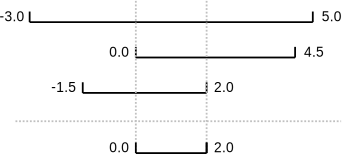

In [4]:
from IPython.display import Image, SVG
import pytest
SVG('http://swcarpentry.github.io/python-novice-inflammation/fig/python-overlapping-ranges.svg')

Most novice programmers would solve this problem like this:

Write a function range_overlap.
Call it interactively on two or three different inputs.
If it produces the wrong answer, fix the function and re-run that test.
This clearly works — after all, thousands of scientists are doing it right now — but there’s a better way:

Write a short function for each test.
Write a range_overlap function that should pass those tests.
If range_overlap produces any wrong answers, fix it and re-run the test functions.
Writing the tests before writing the function they exercise is called test-driven development (TDD). Its advocates believe it produces better code faster because:

If people write tests after writing the thing to be tested, they are subject to confirmation bias, i.e., they subconsciously write tests to show that their code is correct, rather than to find errors.
Writing tests helps programmers figure out what the function is actually supposed to do.
Here are three test functions for range_overlap:



In [6]:
assert range_overlap([ (0.0, 1.0) ]) == (0.0, 1.0)
assert range_overlap([ (2.0, 3.0), (2.0, 4.0) ]) == (2.0, 3.0)
assert range_overlap([ (0.0, 1.0), (0.0, 2.0), (-1.0, 1.0) ]) == (0.0, 1.0)

NameError: name 'range_overlap' is not defined

The error is actually reassuring: we haven’t written range_overlap yet, so if the tests passed, it would be a sign that someone else had and that we were accidentally using their function.

And as a bonus of writing these tests, we’ve implicitly defined what our input and output look like: we expect a list of pairs as input, and produce a single pair as output.

Something important is missing, though. We don’t have any tests for the case where the ranges don’t overlap at all:



In [7]:
assert range_overlap([ (0.0, 1.0), (5.0, 6.0) ]) == ???


SyntaxError: invalid syntax (<ipython-input-7-cf12f48f208b>, line 1)

What should range_overlap do in this case: fail with an error message, produce a special value like (0.0, 0.0) to signal that there’s no overlap, or something else? Any actual implementation of the function will do one of these things; writing the tests first helps us figure out which is best before we’re emotionally invested in whatever we happened to write before we realized there was an issue.

And what about this case?

In [8]:
assert range_overlap([ (0.0, 1.0), (1.0, 2.0) ]) == ???


SyntaxError: invalid syntax (<ipython-input-8-79ff80dec5ad>, line 1)

Do two segments that touch at their endpoints overlap or not? Mathematicians usually say “yes”, but engineers usually say “no”. The best answer is “whatever is most useful in the rest of our program”, but again, any actual implementation of range_overlap is going to do something, and whatever it is ought to be consistent with what it does when there’s no overlap at all.

Since we’re planning to use the range this function returns as the X axis in a time series chart, we decide that:

every overlap has to have non-zero width, and
we will return the special value None when there’s no overlap.
None is built into Python, and means “nothing here”. (Other languages often call the equivalent value null or nil). With that decision made, we can finish writing our last two tests:

In [9]:
assert range_overlap([ (0.0, 1.0), (5.0, 6.0) ]) == None
assert range_overlap([ (0.0, 1.0), (1.0, 2.0) ]) == None


NameError: name 'range_overlap' is not defined

Again, we get an error because we haven’t written our function, but we’re now ready to do so:



In [11]:
def range_overlap(ranges):
    '''Return common overlap among a set of [low, high] ranges.'''
    lowest = 0.0
    highest = 1.0
    for (low, high) in ranges:
        lowest = max(lowest, low)
        highest = min(highest, high)
    return (lowest, highest)

(Take a moment to think about why we use max to raise lowest and min to lower highest). We’d now like to re-run our tests, but they’re scattered across three different cells. To make running them easier, let’s put them all in a function:



In [12]:
def test_range_overlap():
    assert range_overlap([ (0.0, 1.0), (5.0, 6.0) ]) == None
    assert range_overlap([ (0.0, 1.0), (1.0, 2.0) ]) == None
    assert range_overlap([ (0.0, 1.0) ]) == (0.0, 1.0)
    assert range_overlap([ (2.0, 3.0), (2.0, 4.0) ]) == (2.0, 3.0)
    assert range_overlap([ (0.0, 1.0), (0.0, 2.0), (-1.0, 1.0) ]) == (0.0, 1.0)

We can now test range_overlap with a single function call:



In [13]:
test_range_overlap()


AssertionError: 

The first test that was supposed to produce None fails, so we know something is wrong with our function. We don’t know whether the other tests passed or failed because Python halted the program as soon as it spotted the first error. Still, some information is better than none, and if we trace the behavior of the function with that input, we realize that we’re initializing lowest and highest to 0.0 and 1.0 respectively, regardless of the input values. This violates another important rule of programming: always initialize from data.




## Palindromes

A classic basic programming task is to check whether a string is a palindrome. 

So the most simple palindrome we could have is a string containing a single character. So lets start by writing a test for that case

In [36]:
from ipywidgets import widgets

In [37]:
def test_is_palindrome():
    assert is_palindrome("a") == True



Now that we have written our first test case, lets write the simplest code we can that will pass our test case.

In [38]:
def is_palindrome(pal):
    return len(pal) == 1

test_is_palindrome()

Our code has passed our test. Amazing. So lets add another test case, which is a bit more complex, and we suspect our code will fail to pass.

In [39]:
def test_is_palindrome():
    assert is_palindrome("a") == True
    assert is_palindrome("bb" )== True
    
test_is_palindrome()

AssertionError: 

With the addition of the new test case, our code is no longer passing all the tests. So once again we are going to change our program to handle the new test case. When attempting this section, it is probably easiest to use Pythons built in list operations, but you can use loops if you so desire.

In [40]:
def is_palindrome(pal):
    return pal[::-1]==pal
test_is_palindrome()


Once again our code is passing all our tests. It may feel as though we have finished with our 
    is_palindrome
function, it seems to be working ok. But what about some more "real world" cases. For example, which happens if there is leading or trailing whitespace in the string we are checking i.e "   kayak ". 

In [41]:
def test_is_palindrome():
    assert is_palindrome("a") == True
    assert is_palindrome("bb")==True
    assert is_palindrome("ab3d")==False
    assert is_palindrome("  kayak ")==True
test_is_palindrome()

AssertionError: 

Our code didn't pass our new test. So we need to take out the whitespace at the start and end of the string "  kayak ". Python strings have inbuilt methods which can do this for us. I suggest you try google your way out of this one. In all seriousness, programming involves a fair amount of googling; don't try and re invent the wheel but at the same time don't blindy copy and paste code. [Stackoverflow](Stackoverflow.com) is an excellent resource for answering programming related questions, there is a good chance someone has already asked the question you have.

In [42]:
def is_palindrome(pal):
    pal=pal.strip()
    return pal[::-1]==pal

test_is_palindrome()


Now that we can handle whitespace, what about other characters, such as numbers and capital letters? 

In [43]:
def test_is_palindrome():
    assert is_palindrome("a") == True
    assert is_palindrome("bb")==True
    assert is_palindrome("  kayak")==True
    assert is_palindrome("d33d")==True
    assert is_palindrome(" Noon   ")==True
test_is_palindrome()

AssertionError: 

In [44]:
def is_palindrome(pal):
    pal=pal.lower()
    pal=pal.strip()
    return pal[::-1]==pal

test_is_palindrome()

Finally, what about punctuation? should we specify that it is part of the palindrome, or ignore it? If you are feeling up for it, try implement a version of 
    is_palindrome
that removes all punctuation from the test string. Check that it passes the new test added.

In [49]:
def test_is_palindrome():
    assert is_palindrome("a") == True
    assert is_palindrome("bb")==True
    assert is_palindrome("ab3d")==False
    assert is_palindrome("  kayak")==True
    assert is_palindrome(" Noon   ")==True
    assert is_palindrome("\"Sirrah! Deliver deified desserts detartrated!\" stressed deified, reviled Harris.")==True
test_is_palindrome()




AssertionError: 

## Naming standards for our tests

So far we have been lumping all our tests together inside a single function. There are a couple of issues with this. When a test fails, the remaining tests will not run. Secondly, its hard to know exactally which test failed and why, we have to inspect the arguments we passed to our palindrome function to work out exactally what we are testing. So the first thing we need to do is split our tests into different function, one function per test. After that we need to name our functions so that we can work out what they are testing soley based on the name. 

So how do we name our test functions? There are no hard and fast rules, but a common way to name a test is **test\_\[test\_name\]**. Following these conventions our palindrome tests would look like the following

In [50]:

def test_single_character_palindrome():
    assert is_palindrome("a") == True
    
def test_two_same_character_palindrome():
    assert is_palindrome("bb")==True
    
def test_numbers_not_palindrome():
    assert is_palindrome("ab3d")==False
    
def test_spacing_palindrome():
    assert is_palindrome("  kayak")==True
    
def test_capitals_palindrome():
    assert is_palindrome(" Noon   ")==True
    
def test_punctuation_palindrome():
    assert is_palindrome("\"Sirrah! Deliver deified desserts detartrated!\" stressed deified, reviled Harris.")==True

When renaming the tests, you can also include the expected state of the test, as shown above where we have indicated whether or not we expect it to be a palindrome.

## Organising Tests

While you can include tests inside the module you are testing, it is better to write them in a external module. When you are making changes to your code, it will be more straightforward if they are elsewhere. Fewer lines of code is generally alot easier when renaming, moving etc.

# Testing with Pytest

There are several popular testing libraries for Python. In this exercise we are going to use the Pytest library. Pytest is very powerful and has a wide number of features, but is easy to get started with. As you become more proficent with Python, you will find more and more of its features useful. Pytest lets us write tests similar to how we have been doing so in this notebook, writing functions that use assert to compare the output of the tested function against the expected return value. Pytest also sniffs out python test files, any files that start with "test\_" or finish with "\_test" (excluding the .py file extention) will be found and run by Pytest.

## Basic Usage

Using pytest is quite straightforward. 